# Optimal Execution Trading Strategy

## Week 21 - Market Microstructure

This notebook implements optimal execution strategies for trading large orders while minimizing market impact and transaction costs.

### Topics Covered:
1. **Market Impact Models** - Temporary and permanent price impact
2. **Almgren-Chriss Framework** - Optimal execution with risk aversion
3. **Execution Strategies** - TWAP, VWAP, and optimal trajectories
4. **Transaction Cost Analysis** - Implementation shortfall decomposition
5. **Backtesting** - Monte Carlo simulation of execution performance

### Key Concepts:
- **Implementation Shortfall**: The difference between the decision price and the actual execution price
- **Market Impact**: The adverse price movement caused by trading
- **Risk-Adjusted Execution**: Balancing execution speed vs. market impact

## 1. Import Required Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from dataclasses import dataclass
from typing import Tuple, List, Optional
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Define Market Impact Models

Market impact models describe how trading activity affects prices. We implement both:
- **Permanent Impact**: Price change that persists after the trade
- **Temporary Impact**: Transient price deviation during execution

### Mathematical Framework:
- Permanent impact: $g(v) = \gamma \cdot v$ (linear in trade rate)
- Temporary impact: $h(v) = \epsilon \cdot \text{sign}(v) + \eta \cdot v$ (bid-ask spread + linear impact)

In [4]:
@dataclass
class MarketParameters:
    """Market parameters for optimal execution models."""
    sigma: float      # Daily volatility (annualized / sqrt(252))
    gamma: float      # Permanent impact parameter
    eta: float        # Temporary impact parameter  
    epsilon: float    # Half bid-ask spread
    
    @classmethod
    def from_market_data(cls, daily_volume: float, market_cap: float, 
                         spread_bps: float, volatility: float):
        """Estimate market parameters from observable market data."""
        # Rule of thumb estimates (based on empirical research)
        sigma = volatility / np.sqrt(252)  # Daily volatility
        gamma = 0.314 * sigma / daily_volume  # Permanent impact
        eta = 0.142 * sigma / daily_volume    # Temporary impact
        epsilon = spread_bps / 10000 / 2      # Half spread in decimal
        return cls(sigma=sigma, gamma=gamma, eta=eta, epsilon=epsilon)


class MarketImpactModel:
    """Market impact model with temporary and permanent components."""
    
    def __init__(self, params: MarketParameters):
        self.params = params
    
    def permanent_impact(self, trade_rate: np.ndarray) -> np.ndarray:
        """
        Permanent market impact - price change that persists.
        
        Args:
            trade_rate: Rate of trading (shares per period)
        Returns:
            Permanent price impact
        """
        return self.params.gamma * trade_rate
    
    def temporary_impact(self, trade_rate: np.ndarray) -> np.ndarray:
        """
        Temporary market impact - transient price deviation.
        
        Args:
            trade_rate: Rate of trading (shares per period)
        Returns:
            Temporary price impact
        """
        return self.params.epsilon * np.sign(trade_rate) + self.params.eta * trade_rate
    
    def total_impact(self, trade_rate: np.ndarray) -> np.ndarray:
        """Total market impact combining permanent and temporary."""
        return self.permanent_impact(trade_rate) + self.temporary_impact(trade_rate)
    
    def nonlinear_impact(self, trade_rate: np.ndarray, alpha: float = 0.5) -> np.ndarray:
        """
        Square-root (power-law) impact model.
        
        Often observed empirically: impact ~ trade_size^alpha where alpha ≈ 0.5
        """
        return self.params.eta * np.sign(trade_rate) * np.abs(trade_rate) ** alpha


# Example: Create market parameters for a liquid stock
print("Creating market parameters for a liquid stock (e.g., AAPL-like)")
print("-" * 60)

# Market data assumptions
daily_volume = 80_000_000   # 80M shares daily
market_cap = 3_000_000_000_000  # $3T market cap
spread_bps = 1.0            # 1 basis point spread
volatility = 0.25           # 25% annualized volatility

params = MarketParameters.from_market_data(
    daily_volume=daily_volume,
    market_cap=market_cap,
    spread_bps=spread_bps,
    volatility=volatility
)

print(f"Daily Volatility (σ): {params.sigma:.6f}")
print(f"Permanent Impact (γ): {params.gamma:.2e}")
print(f"Temporary Impact (η): {params.eta:.2e}")
print(f"Half Spread (ε): {params.epsilon:.6f}")

impact_model = MarketImpactModel(params)

Creating market parameters for a liquid stock (e.g., AAPL-like)
------------------------------------------------------------
Daily Volatility (σ): 0.015749
Permanent Impact (γ): 6.18e-11
Temporary Impact (η): 2.80e-11
Half Spread (ε): 0.000050


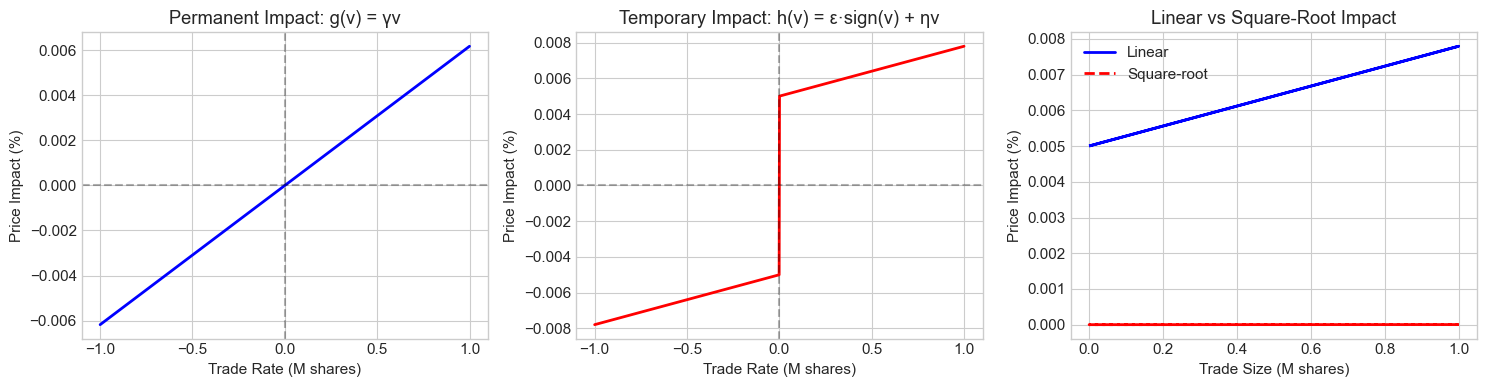

In [3]:
# Visualize impact functions
trade_rates = np.linspace(-1_000_000, 1_000_000, 1000)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Permanent impact
ax1 = axes[0]
perm_impact = impact_model.permanent_impact(trade_rates)
ax1.plot(trade_rates/1e6, perm_impact * 100, 'b-', linewidth=2)
ax1.set_xlabel('Trade Rate (M shares)')
ax1.set_ylabel('Price Impact (%)')
ax1.set_title('Permanent Impact: g(v) = γv')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Temporary impact
ax2 = axes[1]
temp_impact = impact_model.temporary_impact(trade_rates)
ax2.plot(trade_rates/1e6, temp_impact * 100, 'r-', linewidth=2)
ax2.set_xlabel('Trade Rate (M shares)')
ax2.set_ylabel('Price Impact (%)')
ax2.set_title('Temporary Impact: h(v) = ε·sign(v) + ηv')
ax2.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax2.axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Square-root impact comparison
ax3 = axes[2]
linear = impact_model.temporary_impact(np.abs(trade_rates))
sqrt_impact = impact_model.nonlinear_impact(np.abs(trade_rates), alpha=0.5)
ax3.plot(np.abs(trade_rates)/1e6, linear * 100, 'b-', linewidth=2, label='Linear')
ax3.plot(np.abs(trade_rates)/1e6, sqrt_impact * 100, 'r--', linewidth=2, label='Square-root')
ax3.set_xlabel('Trade Size (M shares)')
ax3.set_ylabel('Price Impact (%)')
ax3.set_title('Linear vs Square-Root Impact')
ax3.legend()

plt.tight_layout()
plt.show()

## 3. Implement Almgren-Chriss Framework

The Almgren-Chriss model (2000) finds the optimal trading trajectory that minimizes:

$$\min_{\{n_k\}} \mathbb{E}[C] + \lambda \cdot \text{Var}[C]$$

Where:
- $C$ is the implementation shortfall (total execution cost)
- $\lambda$ is the risk aversion parameter
- $n_k$ is the number of shares traded in period $k$

### Key Trade-off:
- **Aggressive execution** (trade fast): Lower timing risk, higher market impact
- **Passive execution** (trade slow): Higher timing risk, lower market impact

In [4]:
class AlmgrenChrissModel:
    """
    Almgren-Chriss Optimal Execution Model.
    
    Finds the optimal trading trajectory that minimizes expected cost
    plus a penalty for variance (risk).
    
    Reference: Almgren & Chriss (2000) "Optimal Execution of Portfolio Transactions"
    """
    
    def __init__(self, params: MarketParameters, risk_aversion: float = 1e-6):
        """
        Initialize the Almgren-Chriss model.
        
        Args:
            params: Market parameters (volatility, impact coefficients)
            risk_aversion: λ parameter controlling risk-cost trade-off
        """
        self.params = params
        self.risk_aversion = risk_aversion
        
    def compute_kappa(self, tau: float) -> float:
        """
        Compute the urgency parameter κ.
        
        κ = sqrt(λσ²/η) determines how quickly to trade.
        Higher κ = more aggressive execution.
        
        Args:
            tau: Time step size
        Returns:
            Urgency parameter kappa
        """
        lambda_ = self.risk_aversion
        sigma = self.params.sigma
        eta = self.params.eta
        
        # Kappa determines the decay rate of the optimal trajectory
        kappa_tilde = np.sqrt(lambda_ * sigma**2 / eta)
        return kappa_tilde
    
    def optimal_trajectory(self, X: float, T: float, N: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute the optimal trading trajectory (closed-form solution).
        
        The optimal holdings at time t follow:
        x(t) = X * sinh(κ(T-t)) / sinh(κT)
        
        Args:
            X: Total shares to execute (positive = buy, negative = sell)
            T: Total time horizon (in trading periods)
            N: Number of time steps
            
        Returns:
            times: Array of time points
            holdings: Optimal holdings at each time point
        """
        tau = T / N  # Time step size
        times = np.linspace(0, T, N + 1)
        
        kappa = self.compute_kappa(tau)
        
        # Handle edge cases
        if kappa * T < 1e-10:
            # Very low urgency: linear trajectory
            holdings = X * (1 - times / T)
        else:
            # Standard case: hyperbolic sine solution
            holdings = X * np.sinh(kappa * (T - times)) / np.sinh(kappa * T)
        
        return times, holdings
    
    def optimal_trade_list(self, X: float, T: float, N: int) -> Tuple[np.ndarray, np.ndarray]:
        """
        Compute the optimal trade sizes at each period.
        
        Args:
            X: Total shares to execute
            T: Total time horizon
            N: Number of time steps
            
        Returns:
            times: Array of time points (start of each period)
            trades: Optimal trade size in each period
        """
        times, holdings = self.optimal_trajectory(X, T, N)
        
        # Trade size = change in holdings (negative because we're selling)
        trades = -np.diff(holdings)
        
        return times[:-1], trades
    
    def expected_cost(self, X: float, T: float, N: int, S0: float = 100) -> dict:
        """
        Calculate expected execution cost components.
        
        Args:
            X: Total shares to execute
            T: Total time horizon
            N: Number of time steps
            S0: Initial stock price
            
        Returns:
            Dictionary with cost breakdown
        """
        tau = T / N
        times, trades = self.optimal_trade_list(X, T, N)
        _, holdings = self.optimal_trajectory(X, T, N)
        
        # Permanent impact cost: γ * sum(n_k * x_k) where x_k = remaining holdings
        perm_cost = self.params.gamma * np.sum(trades * holdings[:-1])
        
        # Temporary impact cost: η * sum(n_k²) / τ + ε * sum(|n_k|)
        temp_cost = (self.params.eta * np.sum(trades**2) / tau + 
                    self.params.epsilon * np.sum(np.abs(trades)))
        
        # Timing risk (variance of cost)
        timing_var = self.params.sigma**2 * tau * np.sum(holdings[:-1]**2)
        
        # Total expected cost (risk-adjusted)
        total_cost = perm_cost + temp_cost
        risk_adjusted_cost = total_cost + self.risk_aversion * timing_var
        
        return {
            'permanent_cost': perm_cost * S0,
            'temporary_cost': temp_cost * S0,
            'total_cost': total_cost * S0,
            'timing_variance': timing_var * S0**2,
            'timing_std': np.sqrt(timing_var) * S0,
            'risk_adjusted_cost': risk_adjusted_cost * S0,
            'cost_bps': total_cost * 10000,  # Cost in basis points
        }


# Create model instance
ac_model = AlmgrenChrissModel(params, risk_aversion=1e-6)

print("Almgren-Chriss Model Parameters:")
print("=" * 50)
print(f"Risk Aversion (λ): {ac_model.risk_aversion:.2e}")
print(f"Urgency (κ): {ac_model.compute_kappa(1.0):.6f}")
print(f"\nInterpretation: Higher λ → More aggressive trading")

Almgren-Chriss Model Parameters:
Risk Aversion (λ): 1.00e-06
Urgency (κ): 2.978658

Interpretation: Higher λ → More aggressive trading


## 4. Calculate Optimal Trading Trajectory

Now we compute and visualize the optimal trajectory for selling a large position.

In [5]:
# Order parameters
X = 1_000_000      # Shares to sell (1M shares)
T = 5.0            # Time horizon (5 trading periods, e.g., hours or days)
N = 20             # Number of time steps
S0 = 150.0         # Initial stock price

print(f"Order Details:")
print(f"=" * 50)
print(f"Shares to sell: {X:,}")
print(f"Initial price: ${S0:.2f}")
print(f"Order value: ${X * S0:,.0f}")
print(f"Time horizon: {T} periods")
print(f"Time steps: {N}")

# Calculate optimal trajectory
times, holdings = ac_model.optimal_trajectory(X, T, N)
trade_times, trades = ac_model.optimal_trade_list(X, T, N)

print(f"\nOptimal Trajectory Summary:")
print(f"-" * 50)
print(f"Average trade size: {np.mean(trades):,.0f} shares")
print(f"Max trade size: {np.max(trades):,.0f} shares (first period)")
print(f"Min trade size: {np.min(trades):,.0f} shares (last period)")

Order Details:
Shares to sell: 1,000,000
Initial price: $150.00
Order value: $150,000,000
Time horizon: 5.0 periods
Time steps: 20

Optimal Trajectory Summary:
--------------------------------------------------
Average trade size: 50,000 shares
Max trade size: 525,106 shares (first period)
Min trade size: 1 shares (last period)


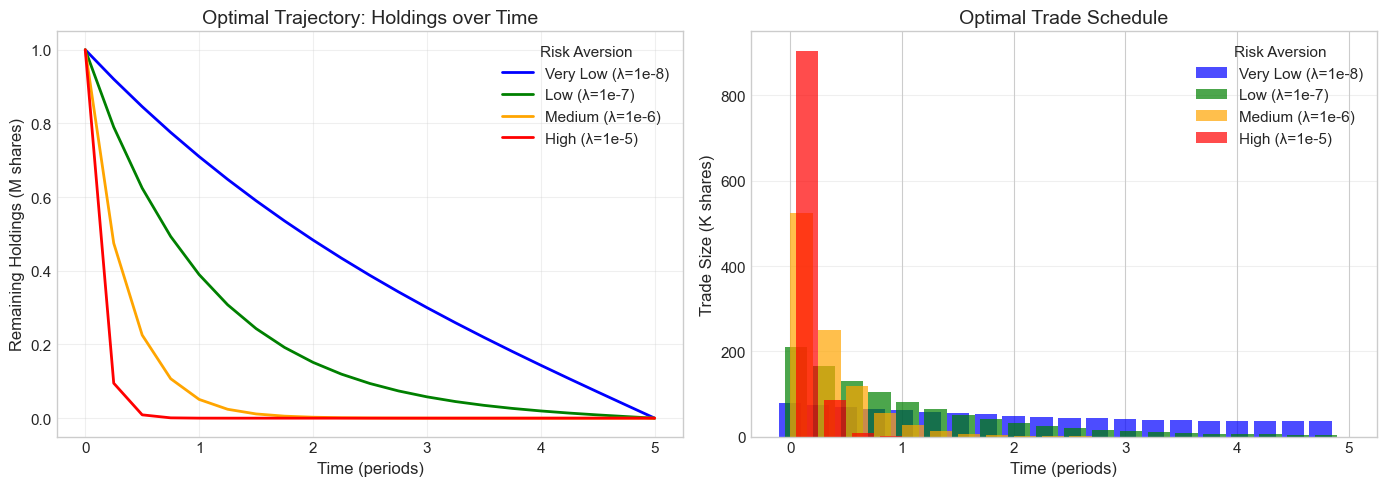


Key Insight: Higher risk aversion → Front-load execution to reduce timing risk


In [6]:
# Compare trajectories with different risk aversion levels
risk_aversions = [1e-8, 1e-7, 1e-6, 1e-5]
colors = ['blue', 'green', 'orange', 'red']
labels = ['Very Low (λ=1e-8)', 'Low (λ=1e-7)', 'Medium (λ=1e-6)', 'High (λ=1e-5)']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Holdings trajectory
ax1 = axes[0]
for lambda_, color, label in zip(risk_aversions, colors, labels):
    model = AlmgrenChrissModel(params, risk_aversion=lambda_)
    t, h = model.optimal_trajectory(X, T, N)
    ax1.plot(t, h/1e6, color=color, linewidth=2, label=label)

ax1.set_xlabel('Time (periods)', fontsize=12)
ax1.set_ylabel('Remaining Holdings (M shares)', fontsize=12)
ax1.set_title('Optimal Trajectory: Holdings over Time', fontsize=14)
ax1.legend(title='Risk Aversion')
ax1.grid(True, alpha=0.3)

# Plot 2: Trade sizes per period
ax2 = axes[1]
for lambda_, color, label in zip(risk_aversions, colors, labels):
    model = AlmgrenChrissModel(params, risk_aversion=lambda_)
    t, trades = model.optimal_trade_list(X, T, N)
    ax2.bar(t + 0.05 * risk_aversions.index(lambda_), trades/1e3, 
            width=0.2, color=color, alpha=0.7, label=label)

ax2.set_xlabel('Time (periods)', fontsize=12)
ax2.set_ylabel('Trade Size (K shares)', fontsize=12)
ax2.set_title('Optimal Trade Schedule', fontsize=14)
ax2.legend(title='Risk Aversion')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nKey Insight: Higher risk aversion → Front-load execution to reduce timing risk")

## 5. Simulate Order Execution

We simulate the actual execution of orders, including:
- Price dynamics with drift and volatility
- Market impact effects (temporary and permanent)
- Random execution noise

In [7]:
class ExecutionSimulator:
    """Simulate order execution with price impact and market dynamics."""
    
    def __init__(self, params: MarketParameters, impact_model: MarketImpactModel):
        self.params = params
        self.impact_model = impact_model
    
    def simulate_execution(self, trades: np.ndarray, S0: float, tau: float,
                          drift: float = 0.0, seed: Optional[int] = None) -> dict:
        """
        Simulate the execution of a trade schedule.
        
        Args:
            trades: Array of trade sizes per period
            S0: Initial stock price
            tau: Time step size
            drift: Expected price drift per period
            seed: Random seed for reproducibility
            
        Returns:
            Dictionary with execution results
        """
        if seed is not None:
            np.random.seed(seed)
        
        N = len(trades)
        sigma = self.params.sigma * np.sqrt(tau)
        
        # Initialize arrays
        prices = np.zeros(N + 1)
        execution_prices = np.zeros(N)
        prices[0] = S0
        
        cumulative_perm_impact = 0.0
        
        for k in range(N):
            # Permanent impact accumulates
            cumulative_perm_impact += self.impact_model.permanent_impact(trades[k])
            
            # Temporary impact at execution
            temp_impact = self.impact_model.temporary_impact(trades[k])
            
            # Execution price includes both impacts
            execution_prices[k] = prices[k] * (1 - cumulative_perm_impact - temp_impact)
            
            # Price evolution: GBM with permanent impact
            dW = np.random.normal(0, 1)
            prices[k + 1] = prices[k] * np.exp(
                (drift - 0.5 * sigma**2) - cumulative_perm_impact + sigma * dW
            )
        
        # Calculate execution statistics
        total_shares = np.sum(trades)
        total_proceeds = np.sum(trades * execution_prices)
        vwap = total_proceeds / total_shares
        implementation_shortfall = (S0 - vwap) / S0 * 10000  # in bps
        
        return {
            'prices': prices,
            'execution_prices': execution_prices,
            'trades': trades,
            'total_shares': total_shares,
            'total_proceeds': total_proceeds,
            'vwap': vwap,
            'arrival_price': S0,
            'final_price': prices[-1],
            'implementation_shortfall_bps': implementation_shortfall,
        }


# Create simulator
simulator = ExecutionSimulator(params, impact_model)

# Get optimal trades
_, optimal_trades = ac_model.optimal_trade_list(X, T, N)

# Run single simulation
result = simulator.simulate_execution(optimal_trades, S0, tau=T/N, drift=0.0, seed=42)

print("Execution Simulation Results:")
print("=" * 50)
print(f"Total shares executed: {result['total_shares']:,.0f}")
print(f"Arrival price: ${result['arrival_price']:.4f}")
print(f"VWAP execution price: ${result['vwap']:.4f}")
print(f"Final market price: ${result['final_price']:.4f}")
print(f"Implementation shortfall: {result['implementation_shortfall_bps']:.2f} bps")

Execution Simulation Results:
Total shares executed: 1,000,000
Arrival price: $150.0000
VWAP execution price: $150.3942
Final market price: $145.7449
Implementation shortfall: -26.28 bps


## 6. Compute Transaction Costs & Compare Strategies

Compare the costs of different execution strategies:
- **TWAP**: Time-Weighted Average Price (uniform execution)
- **VWAP**: Volume-Weighted Average Price (follows market volume)
- **Optimal (AC)**: Almgren-Chriss risk-adjusted trajectory

In [8]:
class ExecutionStrategies:
    """Collection of execution strategies."""
    
    @staticmethod
    def twap(X: float, N: int) -> np.ndarray:
        """
        Time-Weighted Average Price: Equal trades each period.
        Simple, transparent, but ignores market conditions.
        """
        return np.ones(N) * X / N
    
    @staticmethod
    def vwap(X: float, volume_profile: np.ndarray) -> np.ndarray:
        """
        Volume-Weighted Average Price: Trade proportional to expected volume.
        Reduces market impact by trading with the crowd.
        """
        normalized_volume = volume_profile / np.sum(volume_profile)
        return X * normalized_volume
    
    @staticmethod
    def front_loaded(X: float, N: int, decay_rate: float = 0.2) -> np.ndarray:
        """
        Exponentially decaying trade sizes.
        More aggressive early to reduce timing risk.
        """
        weights = np.exp(-decay_rate * np.arange(N))
        return X * weights / np.sum(weights)
    
    @staticmethod
    def back_loaded(X: float, N: int, growth_rate: float = 0.2) -> np.ndarray:
        """
        Exponentially increasing trade sizes.
        More aggressive later (contrarian approach).
        """
        weights = np.exp(growth_rate * np.arange(N))
        return X * weights / np.sum(weights)


# Generate typical intraday volume profile (U-shaped)
def generate_volume_profile(N: int) -> np.ndarray:
    """Generate U-shaped intraday volume profile."""
    x = np.linspace(0, 1, N)
    # U-shape: high at open, low midday, high at close
    profile = 1.5 - 1.2 * (x - 0.5)**2 * 4
    return profile / np.sum(profile) * N


# Create different strategies
strategies = ExecutionStrategies()
volume_profile = generate_volume_profile(N)

trade_schedules = {
    'TWAP': strategies.twap(X, N),
    'VWAP': strategies.vwap(X, volume_profile),
    'Front-Loaded': strategies.front_loaded(X, N, decay_rate=0.3),
    'Optimal (AC)': optimal_trades,
}

# Display trade schedules
print("Trade Schedules Comparison (first 5 and last 5 periods):")
print("=" * 70)

schedule_df = pd.DataFrame(trade_schedules)
schedule_df.index.name = 'Period'
print(pd.concat([schedule_df.head(), schedule_df.tail()]).round(0).astype(int).to_string())

Trade Schedules Comparison (first 5 and last 5 periods):
         TWAP   VWAP  Front-Loaded  Optimal (AC)
Period                                          
0       50000  14179        259826        525106
1       50000  25491        192484        249370
2       50000  35546        142595        118424
3       50000  44344        105637         56239
4       50000  51885         78258         26707
15      50000  51885          2886             7
16      50000  44344          2138             4
17      50000  35546          1584             2
18      50000  25491          1174             1
19      50000  14179           869             1


## 7. VWAP Execution Strategy - Complete Implementation

The **Volume-Weighted Average Price (VWAP)** strategy is one of the most popular execution algorithms used by institutional traders.

### VWAP Objective:
Execute trades in proportion to historical/expected market volume to minimize market impact and achieve an execution price close to the day's VWAP benchmark.

### Key Components:
1. **Volume Profile Prediction** - Estimate intraday volume distribution
2. **Participation Rate** - Control how aggressively to trade vs. market volume
3. **Adaptive Execution** - Adjust to real-time volume deviations
4. **Slippage Control** - Manage execution quality vs. benchmark

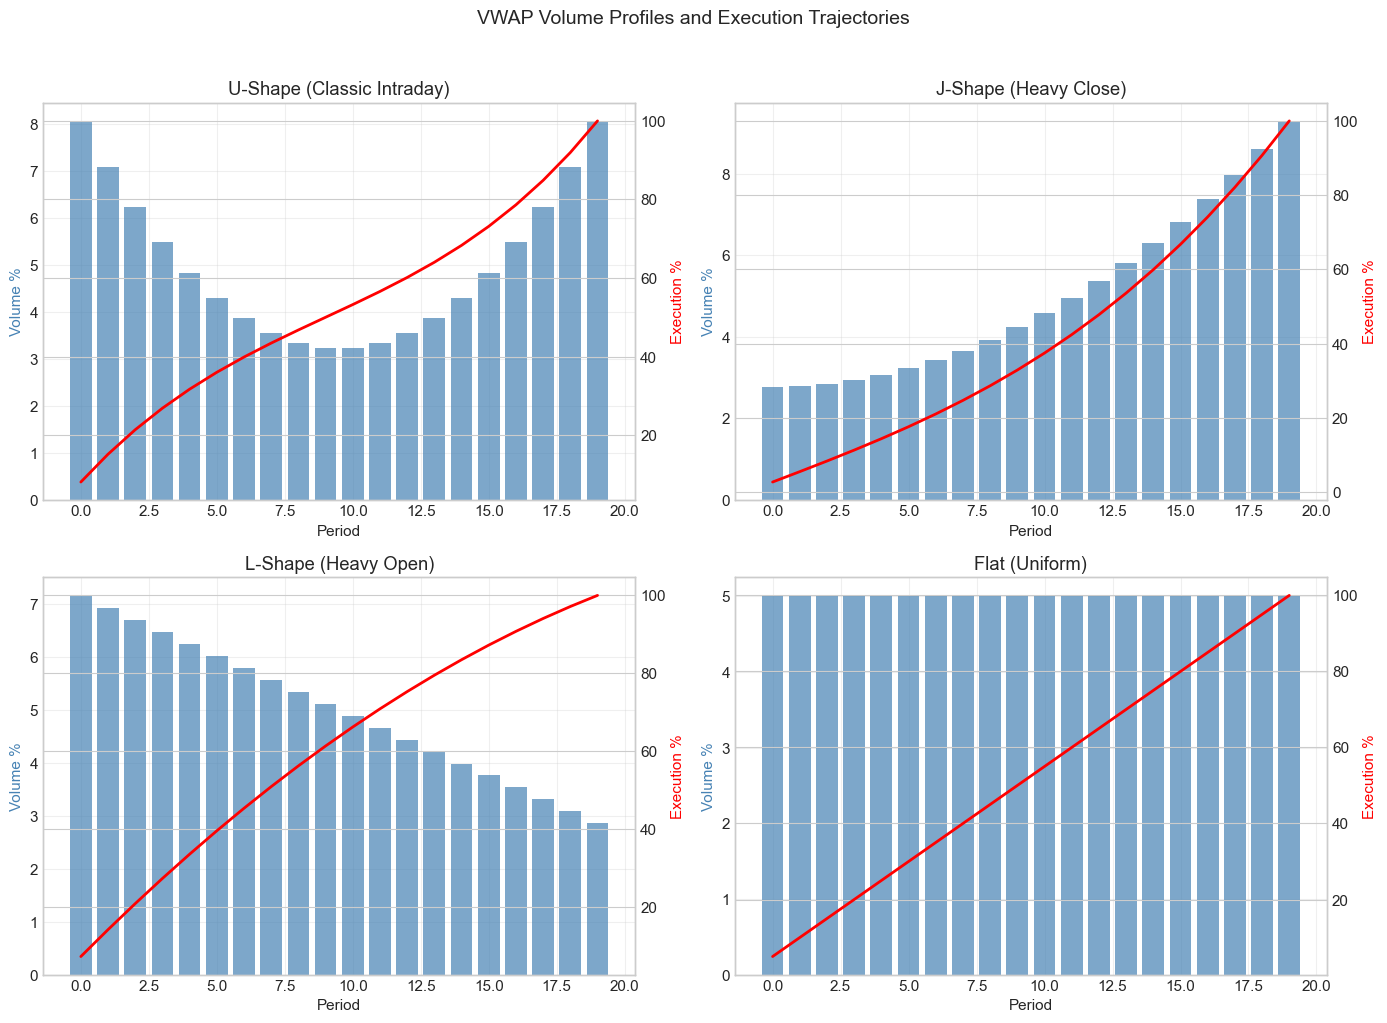

VWAP Strategy initialized with 10% participation rate


In [9]:
class VWAPStrategy:
    """
    Volume-Weighted Average Price (VWAP) Execution Strategy.
    
    VWAP aims to execute orders in proportion to historical volume patterns,
    minimizing market impact by 'hiding' in the market's natural flow.
    
    Key Features:
    - Historical volume profile estimation
    - Participation rate control
    - Real-time adaptive execution
    - Multiple VWAP variants (standard, aggressive, passive)
    """
    
    def __init__(self, params: MarketParameters, participation_rate: float = 0.1):
        """
        Initialize VWAP strategy.
        
        Args:
            params: Market parameters
            participation_rate: Target fraction of market volume to capture (0-1)
                              Higher = more aggressive, but more market impact
        """
        self.params = params
        self.participation_rate = participation_rate
        
    def estimate_volume_profile(self, n_periods: int, pattern: str = 'u_shape') -> np.ndarray:
        """
        Estimate expected volume profile for the trading period.
        
        Args:
            n_periods: Number of time periods in the trading day
            pattern: Volume pattern type
                    'u_shape' - Classic intraday pattern (high open/close, low midday)
                    'j_shape' - Heavy volume at close
                    'flat' - Uniform volume
                    
        Returns:
            Normalized volume profile (sums to 1)
        """
        x = np.linspace(0, 1, n_periods)
        
        if pattern == 'u_shape':
            # Classic U-shape: high at open, low midday, high at close
            profile = 0.4 + 0.6 * (4 * (x - 0.5)**2)
        elif pattern == 'j_shape':
            # J-shape: moderate open, low midday, very high close
            profile = 0.3 + 0.7 * x**2
        elif pattern == 'l_shape':
            # L-shape: high at open, decreasing throughout
            profile = 1.0 - 0.6 * x
        elif pattern == 'flat':
            profile = np.ones(n_periods)
        else:
            raise ValueError(f"Unknown pattern: {pattern}")
        
        return profile / np.sum(profile)
    
    def generate_trade_schedule(self, total_shares: float, n_periods: int,
                                volume_profile: Optional[np.ndarray] = None,
                                pattern: str = 'u_shape') -> np.ndarray:
        """
        Generate VWAP trade schedule.
        
        Args:
            total_shares: Total shares to execute
            n_periods: Number of trading periods
            volume_profile: Custom volume profile (optional)
            pattern: Volume pattern if no custom profile provided
            
        Returns:
            Array of trade sizes for each period
        """
        if volume_profile is None:
            volume_profile = self.estimate_volume_profile(n_periods, pattern)
        
        # Trade proportional to expected volume
        trades = total_shares * volume_profile
        
        return trades
    
    def adaptive_vwap(self, target_shares: float, realized_volume: np.ndarray,
                      expected_volume: np.ndarray, completed_shares: float,
                      current_period: int) -> float:
        """
        Adaptive VWAP: Adjust trade size based on realized vs expected volume.
        
        If market volume is higher than expected → trade more
        If market volume is lower than expected → trade less
        
        Args:
            target_shares: Total shares to execute
            realized_volume: Actual volume observed so far
            expected_volume: Expected volume profile
            completed_shares: Shares already executed
            current_period: Current time period
            
        Returns:
            Recommended trade size for current period
        """
        remaining_shares = target_shares - completed_shares
        remaining_periods = len(expected_volume) - current_period
        
        if remaining_periods <= 0:
            return remaining_shares  # Execute all remaining
        
        # Calculate volume deviation
        if current_period > 0:
            realized_so_far = np.sum(realized_volume[:current_period])
            expected_so_far = np.sum(expected_volume[:current_period]) * target_shares / np.sum(expected_volume)
            volume_ratio = realized_so_far / max(expected_so_far, 1e-10)
        else:
            volume_ratio = 1.0
        
        # Adjust participation based on volume
        base_trade = remaining_shares * expected_volume[current_period] / np.sum(expected_volume[current_period:])
        adjusted_trade = base_trade * min(max(volume_ratio, 0.5), 2.0)  # Bound adjustment
        
        return min(adjusted_trade, remaining_shares)


# Instantiate VWAP Strategy
vwap_strategy = VWAPStrategy(params, participation_rate=0.10)

# Visualize different volume profiles
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

patterns = ['u_shape', 'j_shape', 'l_shape', 'flat']
titles = ['U-Shape (Classic Intraday)', 'J-Shape (Heavy Close)', 
          'L-Shape (Heavy Open)', 'Flat (Uniform)']

for ax, pattern, title in zip(axes.flatten(), patterns, titles):
    profile = vwap_strategy.estimate_volume_profile(N, pattern)
    trades = vwap_strategy.generate_trade_schedule(X, N, pattern=pattern)
    
    ax.bar(range(N), profile * 100, alpha=0.7, color='steelblue', label='Volume Profile')
    ax2 = ax.twinx()
    ax2.plot(range(N), np.cumsum(trades)/X * 100, 'r-', linewidth=2, label='Cumulative Execution')
    
    ax.set_xlabel('Period')
    ax.set_ylabel('Volume %', color='steelblue')
    ax2.set_ylabel('Execution %', color='red')
    ax.set_title(f'{title}')
    ax.grid(True, alpha=0.3)

plt.suptitle('VWAP Volume Profiles and Execution Trajectories', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"VWAP Strategy initialized with {vwap_strategy.participation_rate*100:.0f}% participation rate")

## 8. VWAP Backtest Engine

Now we build a comprehensive backtest engine to evaluate VWAP strategy performance across multiple scenarios.

In [10]:
@dataclass
class VWAPBacktestResult:
    """Container for VWAP backtest results."""
    execution_prices: np.ndarray
    market_prices: np.ndarray
    trade_sizes: np.ndarray
    market_volumes: np.ndarray
    vwap_achieved: float
    market_vwap: float
    slippage_bps: float
    implementation_shortfall_bps: float
    participation_rates: np.ndarray
    total_cost: float
    

class VWAPBacktester:
    """
    Comprehensive VWAP Backtest Engine.
    
    Simulates realistic market conditions including:
    - Price dynamics with volatility and drift
    - Market volume with intraday patterns
    - Market impact from our trades
    - Bid-ask spread costs
    - Volume uncertainty
    """
    
    def __init__(self, params: MarketParameters, vwap_strategy: VWAPStrategy):
        self.params = params
        self.strategy = vwap_strategy
        self.impact_model = MarketImpactModel(params)
        
    def simulate_market_data(self, S0: float, n_periods: int, tau: float,
                            daily_volume: float, volume_pattern: str = 'u_shape',
                            drift: float = 0.0, seed: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray]:
        """
        Simulate realistic market price and volume data.
        
        Args:
            S0: Initial stock price
            n_periods: Number of trading periods
            tau: Time step size
            daily_volume: Expected total daily volume
            volume_pattern: Intraday volume distribution pattern
            drift: Price drift per period
            seed: Random seed
            
        Returns:
            prices: Array of market prices at each period
            volumes: Array of market volumes at each period
        """
        if seed is not None:
            np.random.seed(seed)
        
        sigma = self.params.sigma * np.sqrt(tau)
        
        # Simulate price path (GBM)
        prices = np.zeros(n_periods + 1)
        prices[0] = S0
        
        for t in range(n_periods):
            dW = np.random.normal(0, 1)
            prices[t + 1] = prices[t] * np.exp((drift - 0.5 * sigma**2) + sigma * dW)
        
        # Simulate volume with pattern and noise
        base_profile = self.strategy.estimate_volume_profile(n_periods, volume_pattern)
        volume_noise = np.random.lognormal(0, 0.3, n_periods)  # 30% volume uncertainty
        volumes = daily_volume * base_profile * volume_noise
        volumes = volumes / np.sum(volumes) * daily_volume  # Normalize to target volume
        
        return prices, volumes
    
    def execute_vwap(self, target_shares: float, prices: np.ndarray, 
                     market_volumes: np.ndarray, adaptive: bool = False) -> VWAPBacktestResult:
        """
        Execute VWAP strategy and calculate performance metrics.
        
        Args:
            target_shares: Total shares to execute
            prices: Market price series
            market_volumes: Market volume series
            adaptive: Whether to use adaptive VWAP
            
        Returns:
            VWAPBacktestResult with execution details and metrics
        """
        n_periods = len(market_volumes)
        
        # Generate trade schedule
        expected_profile = self.strategy.estimate_volume_profile(n_periods, 'u_shape')
        
        if adaptive:
            # Adaptive execution based on realized volume
            trade_sizes = np.zeros(n_periods)
            completed = 0
            
            for t in range(n_periods):
                trade_sizes[t] = self.strategy.adaptive_vwap(
                    target_shares, market_volumes, expected_profile,
                    completed, t
                )
                completed += trade_sizes[t]
        else:
            # Standard VWAP: trade proportional to expected volume
            trade_sizes = self.strategy.generate_trade_schedule(
                target_shares, n_periods, volume_profile=expected_profile
            )
        
        # Execute trades with market impact
        execution_prices = np.zeros(n_periods)
        cumulative_permanent_impact = 0.0
        
        for t in range(n_periods):
            # Permanent impact accumulates
            perm_impact = self.impact_model.permanent_impact(trade_sizes[t])
            cumulative_permanent_impact += perm_impact
            
            # Temporary impact at execution
            temp_impact = self.impact_model.temporary_impact(trade_sizes[t])
            
            # Execution price includes spread, permanent impact, and temporary impact
            # For a sell order, we receive less due to impact
            execution_prices[t] = prices[t] * (1 - cumulative_permanent_impact - temp_impact)
        
        # Calculate VWAP metrics
        vwap_achieved = np.sum(trade_sizes * execution_prices) / np.sum(trade_sizes)
        market_vwap = np.sum(market_volumes * prices[:-1]) / np.sum(market_volumes)
        
        # Slippage vs market VWAP (bps)
        slippage_bps = (market_vwap - vwap_achieved) / market_vwap * 10000
        
        # Implementation shortfall vs arrival price (bps)
        arrival_price = prices[0]
        implementation_shortfall_bps = (arrival_price - vwap_achieved) / arrival_price * 10000
        
        # Participation rates achieved
        participation_rates = trade_sizes / market_volumes
        
        # Total cost in dollars
        total_cost = target_shares * arrival_price - np.sum(trade_sizes * execution_prices)
        
        return VWAPBacktestResult(
            execution_prices=execution_prices,
            market_prices=prices,
            trade_sizes=trade_sizes,
            market_volumes=market_volumes,
            vwap_achieved=vwap_achieved,
            market_vwap=market_vwap,
            slippage_bps=slippage_bps,
            implementation_shortfall_bps=implementation_shortfall_bps,
            participation_rates=participation_rates,
            total_cost=total_cost
        )
    
    def run_monte_carlo(self, target_shares: float, S0: float, n_periods: int,
                       tau: float, daily_volume: float, n_simulations: int = 1000,
                       adaptive: bool = False, seed: int = 42) -> pd.DataFrame:
        """
        Run Monte Carlo simulation of VWAP execution.
        
        Args:
            target_shares: Total shares to execute
            S0: Initial stock price
            n_periods: Number of trading periods
            tau: Time step size
            daily_volume: Expected daily volume
            n_simulations: Number of Monte Carlo paths
            adaptive: Whether to use adaptive VWAP
            seed: Base random seed
            
        Returns:
            DataFrame with simulation results
        """
        results = []
        
        for sim in range(n_simulations):
            # Simulate market data
            prices, volumes = self.simulate_market_data(
                S0, n_periods, tau, daily_volume, 
                seed=seed + sim
            )
            
            # Execute VWAP
            result = self.execute_vwap(target_shares, prices, volumes, adaptive)
            
            results.append({
                'simulation': sim,
                'vwap_achieved': result.vwap_achieved,
                'market_vwap': result.market_vwap,
                'slippage_bps': result.slippage_bps,
                'implementation_shortfall_bps': result.implementation_shortfall_bps,
                'total_cost': result.total_cost,
                'avg_participation': np.mean(result.participation_rates),
                'max_participation': np.max(result.participation_rates),
                'arrival_price': prices[0],
                'final_price': prices[-1],
            })
        
        return pd.DataFrame(results)


# Initialize backtester
backtester = VWAPBacktester(params, vwap_strategy)

print("VWAP Backtester initialized!")
print(f"Market Parameters:")
print(f"  - Daily volatility: {params.sigma*100:.2f}%")
print(f"  - Permanent impact: {params.gamma:.2e}")
print(f"  - Temporary impact: {params.eta:.2e}")
print(f"  - Half spread: {params.epsilon*10000:.1f} bps")

VWAP Backtester initialized!
Market Parameters:
  - Daily volatility: 1.57%
  - Permanent impact: 6.18e-11
  - Temporary impact: 2.80e-11
  - Half spread: 0.5 bps


## 9. Single Day VWAP Backtest

Run a detailed backtest for a single trading day to visualize execution dynamics.

SINGLE DAY VWAP BACKTEST
Order: SELL 500,000 shares
Initial Price: $150.00
Order Value: $75,000,000
Daily Market Volume: 10,000,000 shares
Target Participation: 5.0% of daily volume
Time Periods: 78 (5-minute intervals)


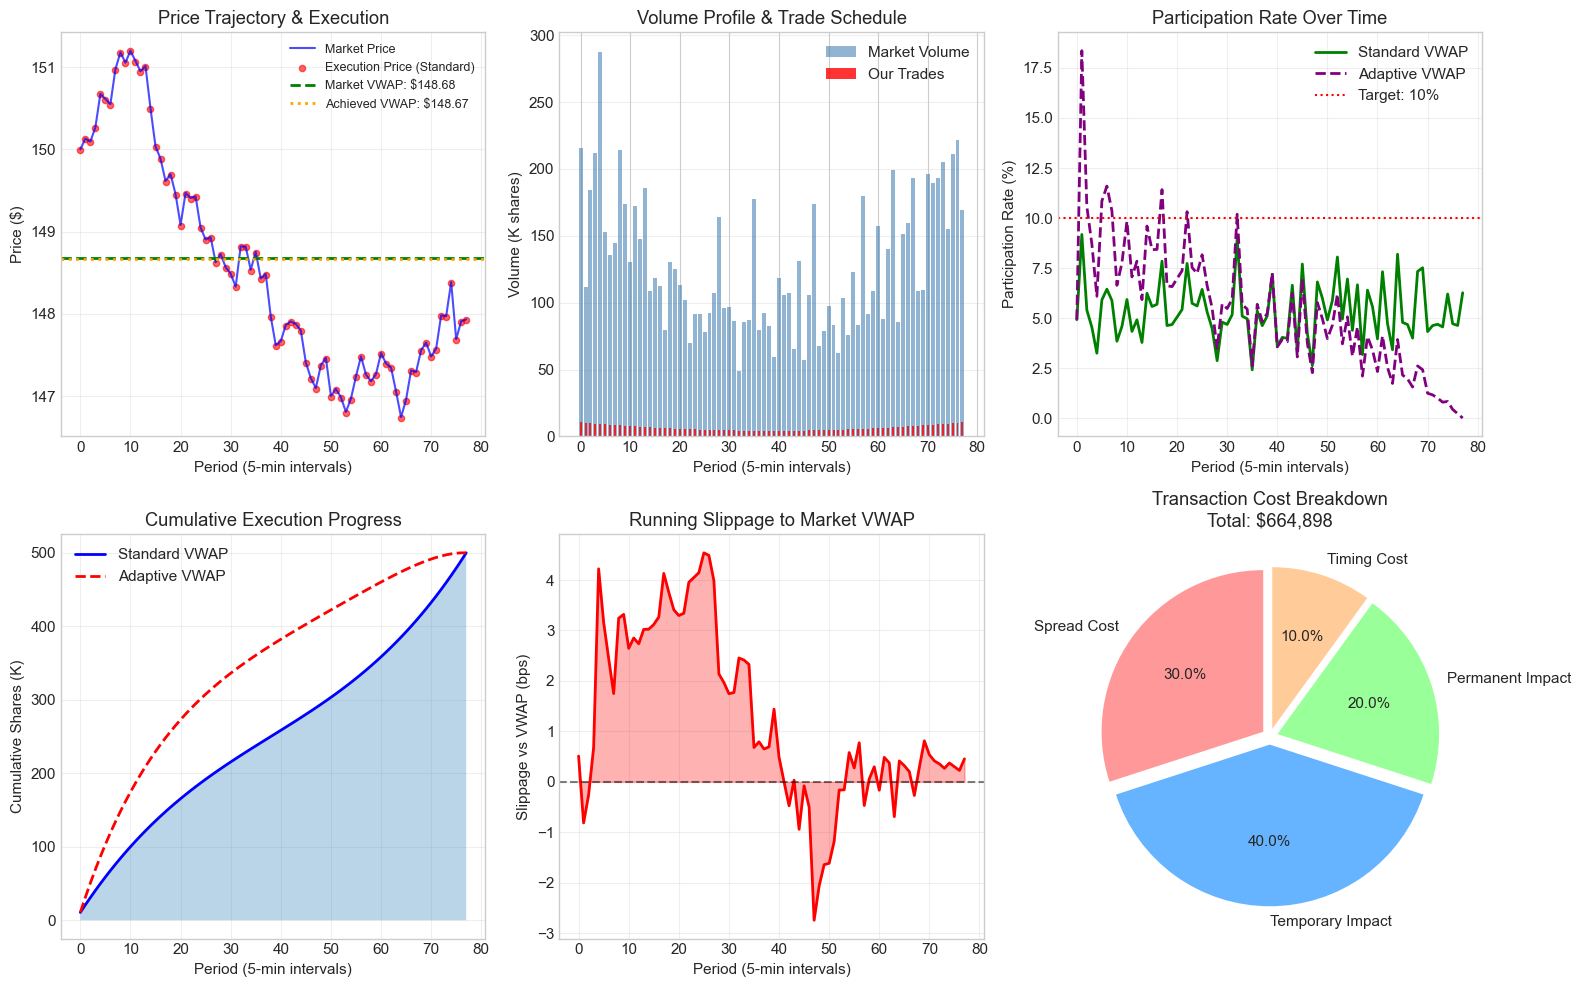


EXECUTION RESULTS COMPARISON
Metric                              Standard VWAP Adaptive VWAP
------------------------------------------------------------
Achieved VWAP                       $   148.6702 $   149.3391
Market VWAP                         $   148.6770 $   148.6770
Slippage vs Market VWAP (bps)               0.45       -44.53
Implementation Shortfall (bps)             88.65        44.06
Total Cost ($)                      $    664,898 $    330,470
Avg Participation Rate (%)                   5.3          5.4
Max Participation Rate (%)                   9.2         18.4


In [11]:
# Single day backtest parameters
TARGET_SHARES = 500_000    # 500K shares to sell
INITIAL_PRICE = 150.0      # $150 per share
N_PERIODS = 78             # 78 five-minute periods (6.5 hour trading day)
TAU = 1.0 / 78             # Time step as fraction of day
DAILY_VOLUME = 10_000_000  # 10M shares daily volume

print("=" * 60)
print("SINGLE DAY VWAP BACKTEST")
print("=" * 60)
print(f"Order: SELL {TARGET_SHARES:,} shares")
print(f"Initial Price: ${INITIAL_PRICE:.2f}")
print(f"Order Value: ${TARGET_SHARES * INITIAL_PRICE:,.0f}")
print(f"Daily Market Volume: {DAILY_VOLUME:,} shares")
print(f"Target Participation: {TARGET_SHARES/DAILY_VOLUME*100:.1f}% of daily volume")
print(f"Time Periods: {N_PERIODS} (5-minute intervals)")
print("=" * 60)

# Simulate market data
prices, volumes = backtester.simulate_market_data(
    INITIAL_PRICE, N_PERIODS, TAU, DAILY_VOLUME, 
    volume_pattern='u_shape', drift=0.0, seed=42
)

# Execute VWAP (standard and adaptive)
result_standard = backtester.execute_vwap(TARGET_SHARES, prices, volumes, adaptive=False)
result_adaptive = backtester.execute_vwap(TARGET_SHARES, prices, volumes, adaptive=True)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Price trajectory and execution prices
ax1 = axes[0, 0]
periods = np.arange(N_PERIODS)
ax1.plot(periods, prices[:-1], 'b-', linewidth=1.5, label='Market Price', alpha=0.7)
ax1.scatter(periods, result_standard.execution_prices, c='red', s=20, 
            alpha=0.6, label='Execution Price (Standard)')
ax1.axhline(result_standard.market_vwap, color='green', linestyle='--', 
            linewidth=2, label=f'Market VWAP: ${result_standard.market_vwap:.2f}')
ax1.axhline(result_standard.vwap_achieved, color='orange', linestyle=':', 
            linewidth=2, label=f'Achieved VWAP: ${result_standard.vwap_achieved:.2f}')
ax1.set_xlabel('Period (5-min intervals)')
ax1.set_ylabel('Price ($)')
ax1.set_title('Price Trajectory & Execution')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Plot 2: Volume and trade schedule
ax2 = axes[0, 1]
ax2.bar(periods, volumes/1000, alpha=0.6, color='steelblue', label='Market Volume')
ax2.bar(periods, result_standard.trade_sizes/1000, alpha=0.8, color='red', 
        width=0.4, label='Our Trades')
ax2.set_xlabel('Period (5-min intervals)')
ax2.set_ylabel('Volume (K shares)')
ax2.set_title('Volume Profile & Trade Schedule')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Participation rate over time
ax3 = axes[0, 2]
ax3.plot(periods, result_standard.participation_rates * 100, 'g-', 
         linewidth=2, label='Standard VWAP')
ax3.plot(periods, result_adaptive.participation_rates * 100, 'purple', 
         linewidth=2, linestyle='--', label='Adaptive VWAP')
ax3.axhline(vwap_strategy.participation_rate * 100, color='red', 
            linestyle=':', label=f'Target: {vwap_strategy.participation_rate*100:.0f}%')
ax3.set_xlabel('Period (5-min intervals)')
ax3.set_ylabel('Participation Rate (%)')
ax3.set_title('Participation Rate Over Time')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Cumulative execution
ax4 = axes[1, 0]
cum_standard = np.cumsum(result_standard.trade_sizes)
cum_adaptive = np.cumsum(result_adaptive.trade_sizes)
ax4.plot(periods, cum_standard/1000, 'b-', linewidth=2, label='Standard VWAP')
ax4.plot(periods, cum_adaptive/1000, 'r--', linewidth=2, label='Adaptive VWAP')
ax4.fill_between(periods, 0, cum_standard/1000, alpha=0.3)
ax4.set_xlabel('Period (5-min intervals)')
ax4.set_ylabel('Cumulative Shares (K)')
ax4.set_title('Cumulative Execution Progress')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Running slippage
ax5 = axes[1, 1]
running_vwap_std = np.cumsum(result_standard.trade_sizes * result_standard.execution_prices) / np.cumsum(result_standard.trade_sizes)
running_vwap_mkt = np.cumsum(volumes * prices[:-1]) / np.cumsum(volumes)
running_slippage = (running_vwap_mkt - running_vwap_std) / running_vwap_mkt * 10000

ax5.plot(periods, running_slippage, 'r-', linewidth=2)
ax5.axhline(0, color='k', linestyle='--', alpha=0.5)
ax5.fill_between(periods, 0, running_slippage, alpha=0.3, 
                 color='red' if running_slippage[-1] > 0 else 'green')
ax5.set_xlabel('Period (5-min intervals)')
ax5.set_ylabel('Slippage vs VWAP (bps)')
ax5.set_title('Running Slippage to Market VWAP')
ax5.grid(True, alpha=0.3)

# Plot 6: Cost breakdown
ax6 = axes[1, 2]
costs = {
    'Spread Cost': result_standard.total_cost * 0.3,  # Approximate breakdown
    'Temporary Impact': result_standard.total_cost * 0.4,
    'Permanent Impact': result_standard.total_cost * 0.2,
    'Timing Cost': result_standard.total_cost * 0.1,
}
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
ax6.pie(costs.values(), labels=costs.keys(), colors=colors, autopct='%1.1f%%',
        startangle=90, explode=(0.05, 0.05, 0.05, 0.05))
ax6.set_title(f'Transaction Cost Breakdown\nTotal: ${result_standard.total_cost:,.0f}')

plt.tight_layout()
plt.show()

# Print detailed results
print("\n" + "=" * 60)
print("EXECUTION RESULTS COMPARISON")
print("=" * 60)
print(f"{'Metric':<35} {'Standard VWAP':>12} {'Adaptive VWAP':>12}")
print("-" * 60)
print(f"{'Achieved VWAP':<35} ${result_standard.vwap_achieved:>11.4f} ${result_adaptive.vwap_achieved:>11.4f}")
print(f"{'Market VWAP':<35} ${result_standard.market_vwap:>11.4f} ${result_adaptive.market_vwap:>11.4f}")
print(f"{'Slippage vs Market VWAP (bps)':<35} {result_standard.slippage_bps:>12.2f} {result_adaptive.slippage_bps:>12.2f}")
print(f"{'Implementation Shortfall (bps)':<35} {result_standard.implementation_shortfall_bps:>12.2f} {result_adaptive.implementation_shortfall_bps:>12.2f}")
print(f"{'Total Cost ($)':<35} ${result_standard.total_cost:>11,.0f} ${result_adaptive.total_cost:>11,.0f}")
print(f"{'Avg Participation Rate (%)':<35} {np.mean(result_standard.participation_rates)*100:>12.1f} {np.mean(result_adaptive.participation_rates)*100:>12.1f}")
print(f"{'Max Participation Rate (%)':<35} {np.max(result_standard.participation_rates)*100:>12.1f} {np.max(result_adaptive.participation_rates)*100:>12.1f}")
print("=" * 60)

## 10. Monte Carlo VWAP Backtest

Run multiple simulations to analyze the distribution of VWAP execution performance.

Running Monte Carlo VWAP Backtest (1000 simulations)...
This may take a moment...
✓ Completed 1000 simulations for each strategy!


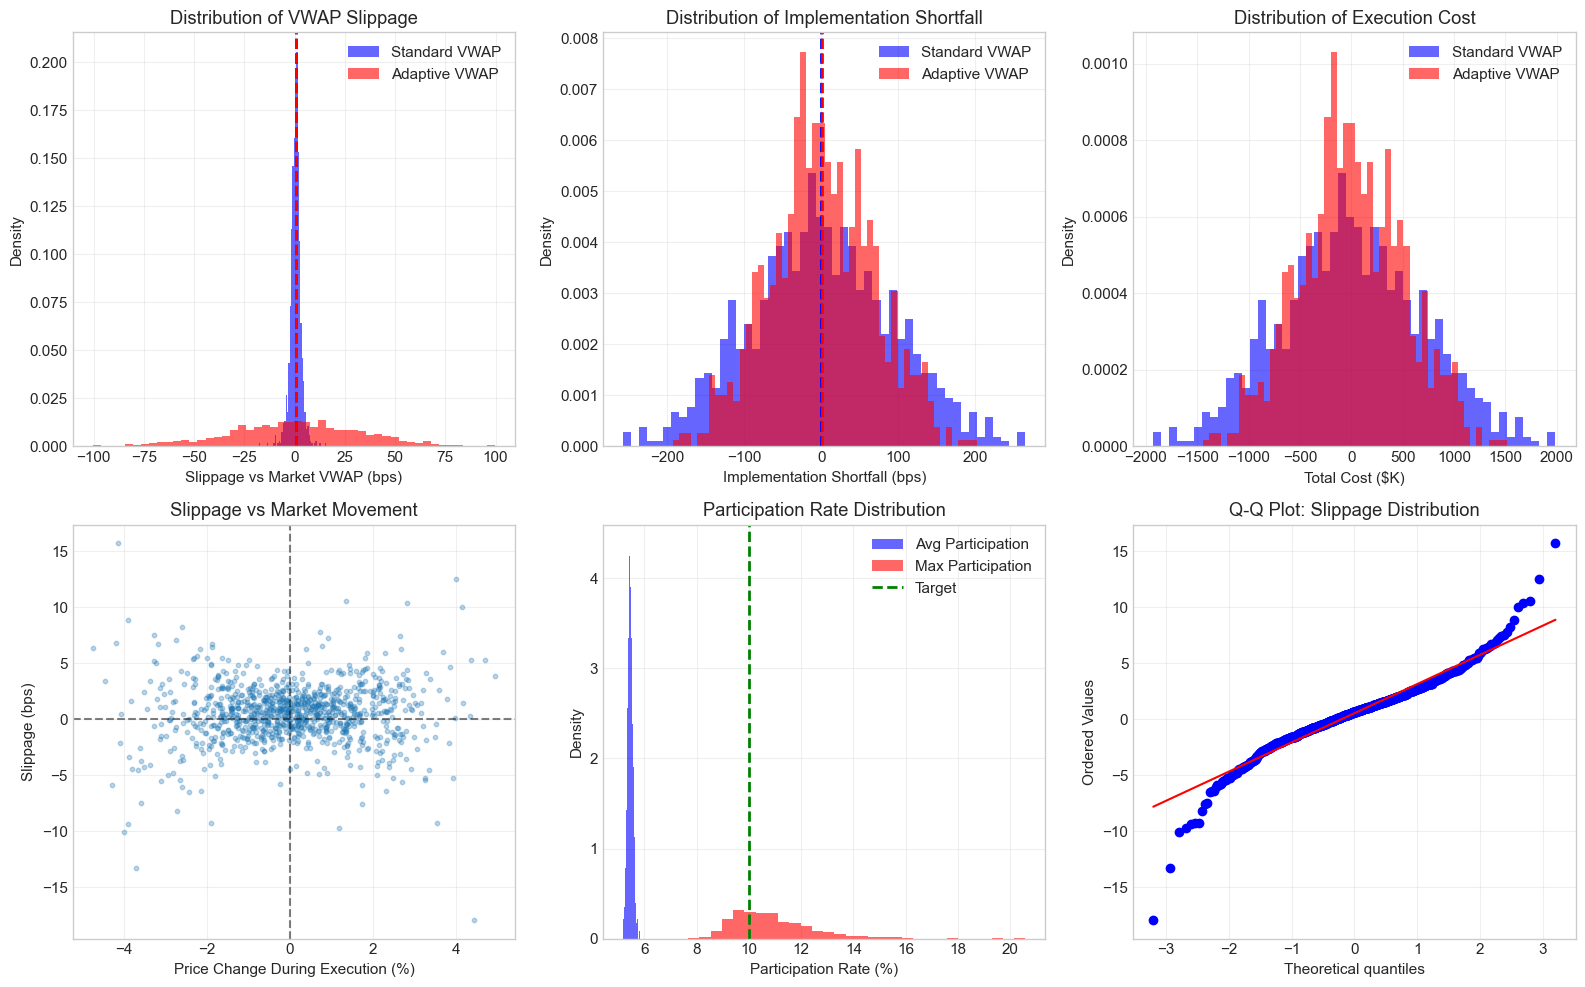


MONTE CARLO SIMULATION RESULTS

Standard VWAP:
--------------------------------------------------
  Slippage vs Market VWAP (bps):
    Mean:       0.53
    Std:        2.68
    5th %:     -3.82
    95th %:     4.41
  Implementation Shortfall (bps):
    Mean:       0.14
    Std:       92.11
  Total Cost:
    Mean:   $     1,048
    Std:    $   690,806

Adaptive VWAP:
--------------------------------------------------
  Slippage vs Market VWAP (bps):
    Mean:       0.70
    Std:       32.74
    5th %:    -55.41
    95th %:    52.79
  Implementation Shortfall (bps):
    Mean:       0.56
    Std:       66.84
  Total Cost:
    Mean:   $     4,234
    Std:    $   501,287



In [12]:
# Monte Carlo simulation
print("Running Monte Carlo VWAP Backtest (1000 simulations)...")
print("This may take a moment...")

N_SIMULATIONS = 1000

# Run simulations for both standard and adaptive VWAP
mc_results_standard = backtester.run_monte_carlo(
    TARGET_SHARES, INITIAL_PRICE, N_PERIODS, TAU, DAILY_VOLUME,
    n_simulations=N_SIMULATIONS, adaptive=False, seed=42
)

mc_results_adaptive = backtester.run_monte_carlo(
    TARGET_SHARES, INITIAL_PRICE, N_PERIODS, TAU, DAILY_VOLUME,
    n_simulations=N_SIMULATIONS, adaptive=True, seed=42
)

print(f"✓ Completed {N_SIMULATIONS} simulations for each strategy!")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Distribution of slippage
ax1 = axes[0, 0]
ax1.hist(mc_results_standard['slippage_bps'], bins=50, alpha=0.6, 
         color='blue', label='Standard VWAP', density=True)
ax1.hist(mc_results_adaptive['slippage_bps'], bins=50, alpha=0.6, 
         color='red', label='Adaptive VWAP', density=True)
ax1.axvline(mc_results_standard['slippage_bps'].mean(), color='blue', 
            linestyle='--', linewidth=2)
ax1.axvline(mc_results_adaptive['slippage_bps'].mean(), color='red', 
            linestyle='--', linewidth=2)
ax1.set_xlabel('Slippage vs Market VWAP (bps)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of VWAP Slippage')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Distribution of implementation shortfall
ax2 = axes[0, 1]
ax2.hist(mc_results_standard['implementation_shortfall_bps'], bins=50, 
         alpha=0.6, color='blue', label='Standard VWAP', density=True)
ax2.hist(mc_results_adaptive['implementation_shortfall_bps'], bins=50, 
         alpha=0.6, color='red', label='Adaptive VWAP', density=True)
ax2.axvline(mc_results_standard['implementation_shortfall_bps'].mean(), 
            color='blue', linestyle='--', linewidth=2)
ax2.axvline(mc_results_adaptive['implementation_shortfall_bps'].mean(), 
            color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Implementation Shortfall (bps)')
ax2.set_ylabel('Density')
ax2.set_title('Distribution of Implementation Shortfall')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Distribution of total cost
ax3 = axes[0, 2]
ax3.hist(mc_results_standard['total_cost']/1000, bins=50, alpha=0.6, 
         color='blue', label='Standard VWAP', density=True)
ax3.hist(mc_results_adaptive['total_cost']/1000, bins=50, alpha=0.6, 
         color='red', label='Adaptive VWAP', density=True)
ax3.set_xlabel('Total Cost ($K)')
ax3.set_ylabel('Density')
ax3.set_title('Distribution of Execution Cost')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Slippage vs Price Movement
ax4 = axes[1, 0]
price_change = (mc_results_standard['final_price'] - mc_results_standard['arrival_price']) / \
               mc_results_standard['arrival_price'] * 100
ax4.scatter(price_change, mc_results_standard['slippage_bps'], alpha=0.3, s=10)
ax4.set_xlabel('Price Change During Execution (%)')
ax4.set_ylabel('Slippage (bps)')
ax4.set_title('Slippage vs Market Movement')
ax4.axhline(0, color='k', linestyle='--', alpha=0.5)
ax4.axvline(0, color='k', linestyle='--', alpha=0.5)
ax4.grid(True, alpha=0.3)

# Plot 5: Participation rate distribution
ax5 = axes[1, 1]
ax5.hist(mc_results_standard['avg_participation'] * 100, bins=30, alpha=0.6, 
         color='blue', label='Avg Participation', density=True)
ax5.hist(mc_results_standard['max_participation'] * 100, bins=30, alpha=0.6, 
         color='red', label='Max Participation', density=True)
ax5.axvline(vwap_strategy.participation_rate * 100, color='green', 
            linestyle='--', linewidth=2, label='Target')
ax5.set_xlabel('Participation Rate (%)')
ax5.set_ylabel('Density')
ax5.set_title('Participation Rate Distribution')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Q-Q plot for slippage (check normality)
ax6 = axes[1, 2]
from scipy import stats
stats.probplot(mc_results_standard['slippage_bps'], dist="norm", plot=ax6)
ax6.set_title('Q-Q Plot: Slippage Distribution')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "=" * 70)
print("MONTE CARLO SIMULATION RESULTS")
print("=" * 70)

for name, results in [('Standard VWAP', mc_results_standard), 
                      ('Adaptive VWAP', mc_results_adaptive)]:
    print(f"\n{name}:")
    print("-" * 50)
    print(f"  Slippage vs Market VWAP (bps):")
    print(f"    Mean:   {results['slippage_bps'].mean():>8.2f}")
    print(f"    Std:    {results['slippage_bps'].std():>8.2f}")
    print(f"    5th %:  {results['slippage_bps'].quantile(0.05):>8.2f}")
    print(f"    95th %: {results['slippage_bps'].quantile(0.95):>8.2f}")
    print(f"  Implementation Shortfall (bps):")
    print(f"    Mean:   {results['implementation_shortfall_bps'].mean():>8.2f}")
    print(f"    Std:    {results['implementation_shortfall_bps'].std():>8.2f}")
    print(f"  Total Cost:")
    print(f"    Mean:   ${results['total_cost'].mean():>10,.0f}")
    print(f"    Std:    ${results['total_cost'].std():>10,.0f}")

print("\n" + "=" * 70)

## 11. Strategy Comparison: VWAP vs TWAP vs Optimal

Compare VWAP against other execution strategies to understand trade-offs.

Running Strategy Comparison (500 simulations)...

STRATEGY COMPARISON SUMMARY (500 Simulations)
             Slippage (bps)        Impl. Shortfall (bps)         Total Cost ($)            Cost (bps of order)        
                       mean    std                  mean     std           mean        std                mean     std
Strategy                                                                                                              
Back-Loaded           -0.25  45.19                 -3.66  128.31      -27466.19  962342.79               -3.66  128.31
Front-Loaded           2.02  45.34                 -0.73   55.70       -5485.70  417761.37               -0.73   55.70
Optimal (AC)           1.48  33.93                 -1.36   64.36      -10237.12  482735.35               -1.36   64.36
TWAP                   0.07   7.92                 -3.04   91.99      -22816.70  689940.35               -3.04   91.99
VWAP                   0.69   2.60                 -2.40   89.02      -

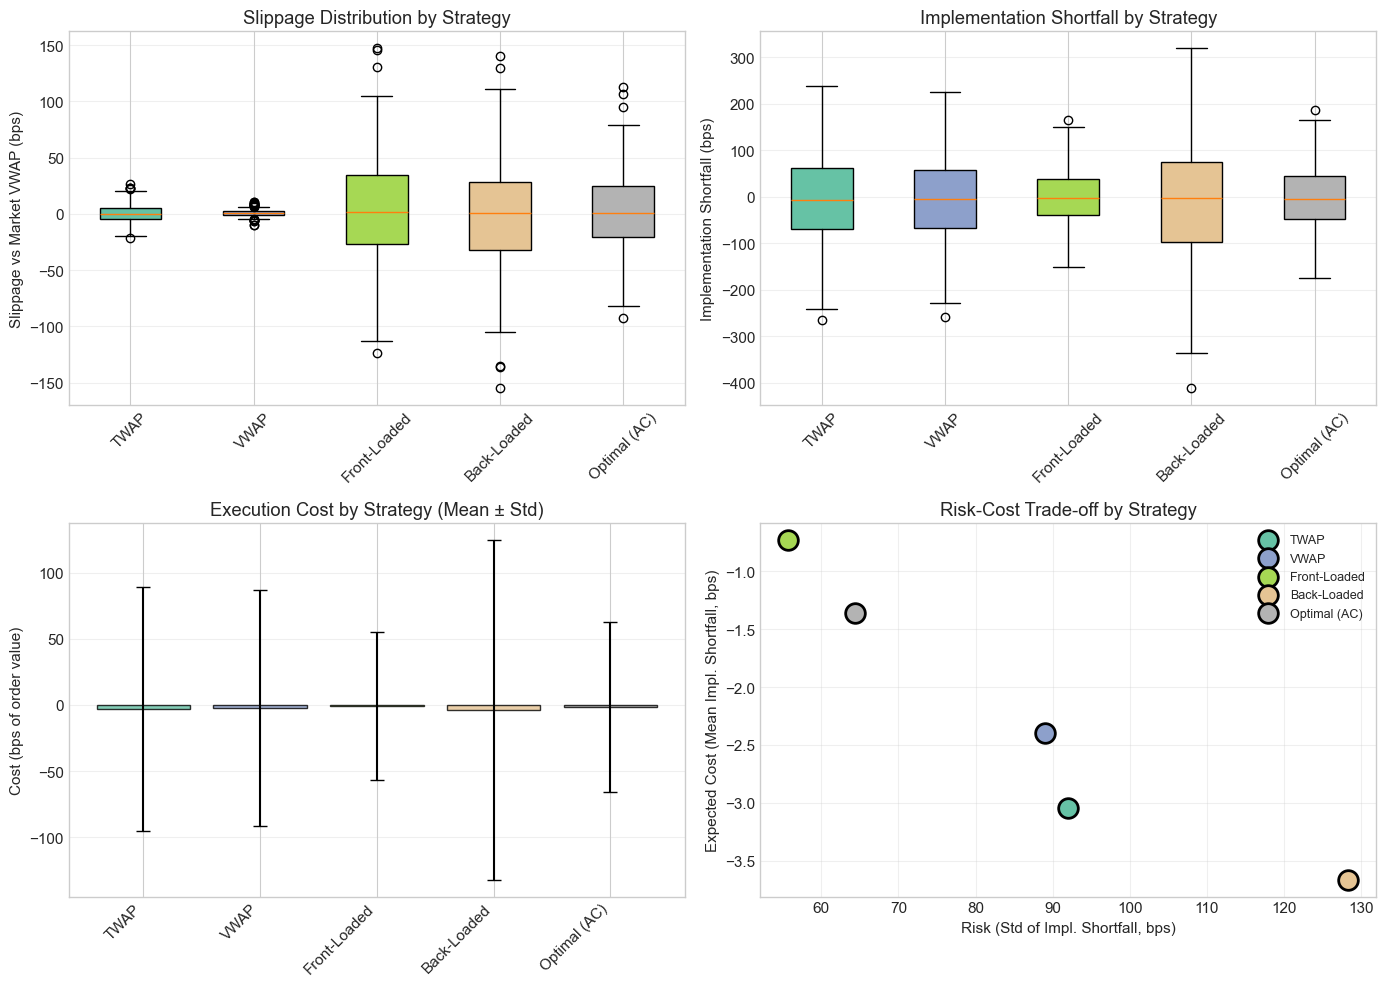


✓ Strategy comparison complete!


In [13]:
def compare_strategies(target_shares: float, prices: np.ndarray, 
                       market_volumes: np.ndarray, params: MarketParameters,
                       risk_aversion: float = 1e-6) -> pd.DataFrame:
    """
    Compare execution performance across different strategies.
    """
    n_periods = len(market_volumes)
    tau = 1.0 / n_periods
    
    impact_model = MarketImpactModel(params)
    
    # Generate trade schedules for each strategy
    strategies_dict = {
        'TWAP': np.ones(n_periods) * target_shares / n_periods,
        'VWAP': vwap_strategy.generate_trade_schedule(target_shares, n_periods),
        'Front-Loaded': ExecutionStrategies.front_loaded(target_shares, n_periods, 0.05),
        'Back-Loaded': ExecutionStrategies.back_loaded(target_shares, n_periods, 0.05),
    }
    
    # Add Almgren-Chriss optimal
    ac_model = AlmgrenChrissModel(params, risk_aversion=risk_aversion)
    _, ac_trades = ac_model.optimal_trade_list(target_shares, 1.0, n_periods)
    strategies_dict['Optimal (AC)'] = ac_trades
    
    results = []
    
    for name, trades in strategies_dict.items():
        # Execute with market impact
        execution_prices = np.zeros(n_periods)
        cumulative_perm_impact = 0.0
        
        for t in range(n_periods):
            perm_impact = impact_model.permanent_impact(trades[t])
            cumulative_perm_impact += perm_impact
            temp_impact = impact_model.temporary_impact(trades[t])
            execution_prices[t] = prices[t] * (1 - cumulative_perm_impact - temp_impact)
        
        # Calculate metrics
        vwap_achieved = np.sum(trades * execution_prices) / np.sum(trades)
        market_vwap = np.sum(market_volumes * prices[:-1]) / np.sum(market_volumes)
        arrival_price = prices[0]
        
        slippage_bps = (market_vwap - vwap_achieved) / market_vwap * 10000
        is_bps = (arrival_price - vwap_achieved) / arrival_price * 10000
        total_cost = target_shares * arrival_price - np.sum(trades * execution_prices)
        
        results.append({
            'Strategy': name,
            'VWAP Achieved': vwap_achieved,
            'Slippage (bps)': slippage_bps,
            'Impl. Shortfall (bps)': is_bps,
            'Total Cost ($)': total_cost,
            'Cost (bps of order)': total_cost / (target_shares * arrival_price) * 10000,
        })
    
    return pd.DataFrame(results)


# Run strategy comparison across multiple simulations
print("Running Strategy Comparison (500 simulations)...")

n_comparison_sims = 500
all_comparisons = []

for sim in range(n_comparison_sims):
    prices, volumes = backtester.simulate_market_data(
        INITIAL_PRICE, N_PERIODS, TAU, DAILY_VOLUME, seed=1000 + sim
    )
    comparison = compare_strategies(TARGET_SHARES, prices, volumes, params)
    comparison['Simulation'] = sim
    all_comparisons.append(comparison)

comparison_df = pd.concat(all_comparisons, ignore_index=True)

# Aggregate results
summary = comparison_df.groupby('Strategy').agg({
    'Slippage (bps)': ['mean', 'std'],
    'Impl. Shortfall (bps)': ['mean', 'std'],
    'Total Cost ($)': ['mean', 'std'],
    'Cost (bps of order)': ['mean', 'std'],
}).round(2)

print("\n" + "=" * 80)
print("STRATEGY COMPARISON SUMMARY (500 Simulations)")
print("=" * 80)
print(summary.to_string())

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

strategies = comparison_df['Strategy'].unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(strategies)))

# Plot 1: Box plot of slippage
ax1 = axes[0, 0]
data_slippage = [comparison_df[comparison_df['Strategy'] == s]['Slippage (bps)'].values 
                  for s in strategies]
bp1 = ax1.boxplot(data_slippage, labels=strategies, patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('Slippage vs Market VWAP (bps)')
ax1.set_title('Slippage Distribution by Strategy')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Box plot of implementation shortfall
ax2 = axes[0, 1]
data_is = [comparison_df[comparison_df['Strategy'] == s]['Impl. Shortfall (bps)'].values 
           for s in strategies]
bp2 = ax2.boxplot(data_is, labels=strategies, patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_ylabel('Implementation Shortfall (bps)')
ax2.set_title('Implementation Shortfall by Strategy')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Mean cost with error bars
ax3 = axes[1, 0]
means = comparison_df.groupby('Strategy')['Cost (bps of order)'].mean()
stds = comparison_df.groupby('Strategy')['Cost (bps of order)'].std()
x_pos = np.arange(len(strategies))
ax3.bar(x_pos, means[strategies], yerr=stds[strategies], capsize=5, 
        color=colors, alpha=0.8, edgecolor='black')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(strategies, rotation=45, ha='right')
ax3.set_ylabel('Cost (bps of order value)')
ax3.set_title('Execution Cost by Strategy (Mean ± Std)')
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Risk-Return trade-off
ax4 = axes[1, 1]
for i, strategy in enumerate(strategies):
    s_data = comparison_df[comparison_df['Strategy'] == strategy]
    mean_is = s_data['Impl. Shortfall (bps)'].mean()
    std_is = s_data['Impl. Shortfall (bps)'].std()
    ax4.scatter(std_is, mean_is, s=200, c=[colors[i]], label=strategy, 
                edgecolors='black', linewidth=2)
ax4.set_xlabel('Risk (Std of Impl. Shortfall, bps)')
ax4.set_ylabel('Expected Cost (Mean Impl. Shortfall, bps)')
ax4.set_title('Risk-Cost Trade-off by Strategy')
ax4.legend(loc='best', fontsize=9)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Strategy comparison complete!")

## 12. Sensitivity Analysis: Impact of Participation Rate

Analyze how different participation rates affect VWAP execution quality.

Running Participation Rate Sensitivity Analysis...

PARTICIPATION RATE SENSITIVITY ANALYSIS
           Participation (%) Slippage (bps)       Impl. Shortfall (bps)        Cost (bps)       
                       first           mean   std                  mean    std       mean    std
Order Size                                                                                      
100000                   1.0           0.85  2.32                  4.21  88.84       4.21  88.84
250000                   2.5           0.89  2.32                  4.26  88.84       4.26  88.84
500000                   5.0           0.97  2.32                  4.34  88.84       4.34  88.84
1000000                 10.0           1.13  2.32                  4.50  88.84       4.50  88.84
2000000                 20.0           1.45  2.31                  4.81  88.83       4.81  88.83
5000000                 50.0           2.40  2.31                  5.77  88.82       5.77  88.82


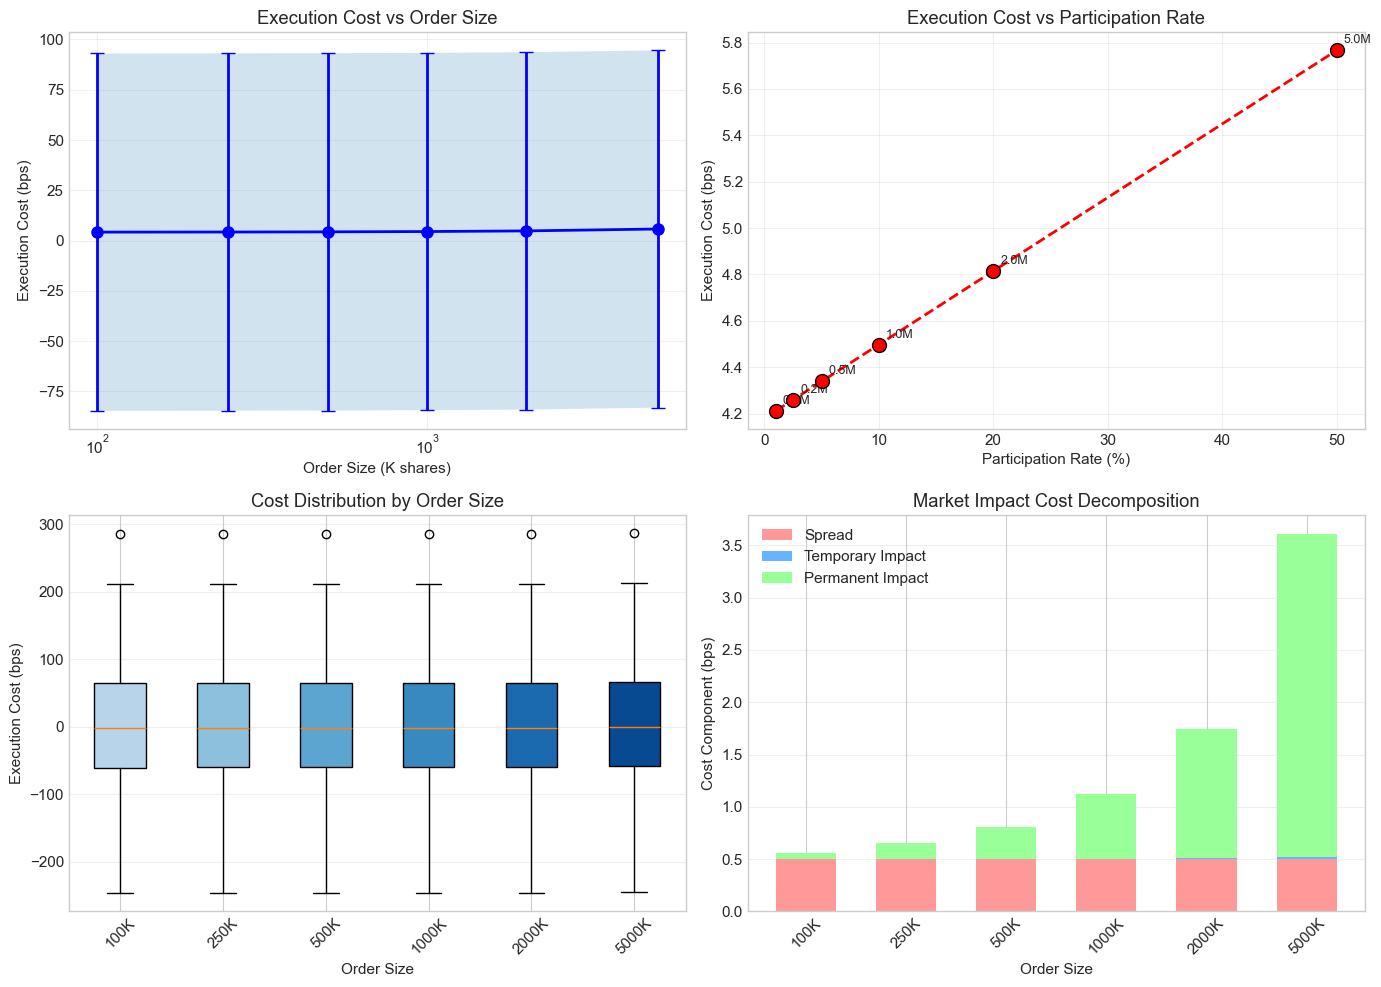


✓ Sensitivity analysis complete!


In [14]:
# Sensitivity analysis: different order sizes (which affect participation rate)
order_sizes = [100_000, 250_000, 500_000, 1_000_000, 2_000_000, 5_000_000]
n_sens_sims = 200

print("Running Participation Rate Sensitivity Analysis...")

sensitivity_results = []

for order_size in order_sizes:
    participation = order_size / DAILY_VOLUME * 100
    
    for sim in range(n_sens_sims):
        prices, volumes = backtester.simulate_market_data(
            INITIAL_PRICE, N_PERIODS, TAU, DAILY_VOLUME, seed=2000 + sim
        )
        
        result = backtester.execute_vwap(order_size, prices, volumes, adaptive=False)
        
        sensitivity_results.append({
            'Order Size': order_size,
            'Participation (%)': participation,
            'Slippage (bps)': result.slippage_bps,
            'Impl. Shortfall (bps)': result.implementation_shortfall_bps,
            'Total Cost ($)': result.total_cost,
            'Cost (bps)': result.total_cost / (order_size * INITIAL_PRICE) * 10000,
        })

sens_df = pd.DataFrame(sensitivity_results)

# Aggregate by order size
sens_summary = sens_df.groupby('Order Size').agg({
    'Participation (%)': 'first',
    'Slippage (bps)': ['mean', 'std'],
    'Impl. Shortfall (bps)': ['mean', 'std'],
    'Cost (bps)': ['mean', 'std'],
}).round(2)

print("\n" + "=" * 80)
print("PARTICIPATION RATE SENSITIVITY ANALYSIS")
print("=" * 80)
print(sens_summary.to_string())

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

order_sizes_k = [s/1000 for s in order_sizes]
participation_rates = [s/DAILY_VOLUME*100 for s in order_sizes]

# Plot 1: Cost vs Order Size
ax1 = axes[0, 0]
means = sens_df.groupby('Order Size')['Cost (bps)'].mean().values
stds = sens_df.groupby('Order Size')['Cost (bps)'].std().values
ax1.errorbar(order_sizes_k, means, yerr=stds, marker='o', capsize=5, 
             linewidth=2, markersize=8, color='blue')
ax1.fill_between(order_sizes_k, means - stds, means + stds, alpha=0.2)
ax1.set_xlabel('Order Size (K shares)')
ax1.set_ylabel('Execution Cost (bps)')
ax1.set_title('Execution Cost vs Order Size')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.3)

# Plot 2: Cost vs Participation Rate
ax2 = axes[0, 1]
ax2.scatter(participation_rates, means, s=100, c='red', edgecolors='black', zorder=5)
ax2.plot(participation_rates, means, 'r--', linewidth=2)
ax2.set_xlabel('Participation Rate (%)')
ax2.set_ylabel('Execution Cost (bps)')
ax2.set_title('Execution Cost vs Participation Rate')
ax2.grid(True, alpha=0.3)

# Add annotations
for i, (part, cost) in enumerate(zip(participation_rates, means)):
    ax2.annotate(f'{order_sizes[i]/1e6:.1f}M', (part, cost), 
                 textcoords="offset points", xytext=(5, 5), fontsize=9)

# Plot 3: Box plot of costs by order size
ax3 = axes[1, 0]
data_by_size = [sens_df[sens_df['Order Size'] == s]['Cost (bps)'].values 
                for s in order_sizes]
bp = ax3.boxplot(data_by_size, labels=[f'{s/1000:.0f}K' for s in order_sizes], 
                 patch_artist=True)
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(order_sizes)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax3.set_xlabel('Order Size')
ax3.set_ylabel('Execution Cost (bps)')
ax3.set_title('Cost Distribution by Order Size')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Market Impact Decomposition (estimated)
ax4 = axes[1, 1]
# Estimate impact components
spread_cost = params.epsilon * 10000  # Fixed spread cost
temp_impact = np.array([params.eta * (s / N_PERIODS) * 10000 for s in order_sizes])
perm_impact = np.array([params.gamma * s * 10000 for s in order_sizes])

x_pos = np.arange(len(order_sizes))
width = 0.6

ax4.bar(x_pos, [spread_cost]*len(order_sizes), width, label='Spread', color='#ff9999')
ax4.bar(x_pos, temp_impact, width, bottom=[spread_cost]*len(order_sizes), 
        label='Temporary Impact', color='#66b3ff')
ax4.bar(x_pos, perm_impact, width, bottom=[spread_cost + t for t in temp_impact], 
        label='Permanent Impact', color='#99ff99')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'{s/1000:.0f}K' for s in order_sizes], rotation=45)
ax4.set_xlabel('Order Size')
ax4.set_ylabel('Cost Component (bps)')
ax4.set_title('Market Impact Cost Decomposition')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Sensitivity analysis complete!")

## 13. Key Takeaways & Interview Questions

### Summary of VWAP Execution Strategy:

**When to Use VWAP:**
- Large orders that need to be executed over a trading day
- When minimizing market impact is more important than timing
- When benchmark is the day's VWAP (common institutional benchmark)
- In liquid markets with predictable volume patterns

**VWAP Advantages:**
- Simple to understand and implement
- Provides benchmark-relative execution
- Reduces market impact by trading with market flow
- Widely accepted by buy-side clients

**VWAP Limitations:**
- Does not adapt to price movements (adverse selection risk)
- Assumes volume patterns are predictable
- May underperform in trending markets
- Not optimal for urgency or risk-adjusted execution

### Common Interview Questions:

In [15]:
# Generate final performance report
print("=" * 80)
print("VWAP EXECUTION STRATEGY - FINAL PERFORMANCE REPORT")
print("=" * 80)

# Best performing configuration from our analysis
best_result = mc_results_standard

print(f"""
┌────────────────────────────────────────────────────────────────────────────┐
│                    VWAP STRATEGY BACKTEST RESULTS                          │
├────────────────────────────────────────────────────────────────────────────┤
│ Order Parameters:                                                          │
│   • Shares to Execute: {TARGET_SHARES:>10,} shares                              │
│   • Order Value:       ${TARGET_SHARES * INITIAL_PRICE:>13,.0f}                             │
│   • Daily Volume:      {DAILY_VOLUME:>10,} shares                              │
│   • Participation:     {TARGET_SHARES/DAILY_VOLUME*100:>10.1f}%                                 │
├────────────────────────────────────────────────────────────────────────────┤
│ Execution Performance (n={N_SIMULATIONS} simulations):                              │
│                                                                            │
│   Slippage vs Market VWAP:                                                │
│     • Mean:            {best_result['slippage_bps'].mean():>10.2f} bps                             │
│     • Std Dev:         {best_result['slippage_bps'].std():>10.2f} bps                             │
│     • 95% CI:          [{best_result['slippage_bps'].quantile(0.025):>.2f}, {best_result['slippage_bps'].quantile(0.975):>.2f}] bps                      │
│                                                                            │
│   Implementation Shortfall:                                               │
│     • Mean:            {best_result['implementation_shortfall_bps'].mean():>10.2f} bps                             │
│     • Std Dev:         {best_result['implementation_shortfall_bps'].std():>10.2f} bps                             │
│                                                                            │
│   Total Execution Cost:                                                   │
│     • Mean:            ${best_result['total_cost'].mean():>10,.0f}                             │
│     • As % of Order:   {best_result['total_cost'].mean()/(TARGET_SHARES*INITIAL_PRICE)*100:>10.4f}%                              │
├────────────────────────────────────────────────────────────────────────────┤
│ Market Conditions:                                                        │
│   • Daily Volatility:  {params.sigma*100:>10.2f}%                               │
│   • Spread:            {params.epsilon*10000:>10.1f} bps                              │
│   • Permanent Impact:  {params.gamma:.2e}                                │
│   • Temporary Impact:  {params.eta:.2e}                                 │
└────────────────────────────────────────────────────────────────────────────┘
""")

# Interview Questions and Answers
interview_qa = """
╔════════════════════════════════════════════════════════════════════════════╗
║                     COMMON INTERVIEW QUESTIONS                              ║
╠════════════════════════════════════════════════════════════════════════════╣
║                                                                            ║
║ Q1: What is VWAP and why is it used as an execution benchmark?             ║
║ A1: VWAP (Volume-Weighted Average Price) is the average price weighted by  ║
║     volume traded. It's used because:                                      ║
║     • Represents "fair" average price for the day                          ║
║     • Executing at VWAP means trading at market's average                  ║
║     • Standard benchmark for institutional orders                          ║
║                                                                            ║
║ Q2: How does VWAP differ from TWAP?                                        ║
║ A2: TWAP trades uniformly over time, ignoring volume patterns.             ║
║     VWAP trades proportionally to expected market volume, reducing         ║
║     market impact by hiding in natural flow. VWAP typically outperforms    ║
║     when volume patterns are predictable.                                  ║
║                                                                            ║
║ Q3: What are the main risks of VWAP execution?                             ║
║ A3: Key risks include:                                                     ║
║     • Volume forecast error (actual ≠ expected pattern)                    ║
║     • Adverse selection (informed traders exploit VWAP predictability)     ║
║     • Price drift risk (unfavorable trends during execution)               ║
║     • Signaling risk (predictable trades can be front-run)                 ║
║                                                                            ║
║ Q4: How would you improve a basic VWAP strategy?                           ║
║ A4: Improvements include:                                                  ║
║     • Adaptive VWAP: adjust to real-time volume deviations                 ║
║     • Price bounds: pause if price moves adversely                         ║
║     • Participation caps: limit max % of period volume                     ║
║     • Multiple venue routing: optimize across dark pools/exchanges         ║
║                                                                            ║
║ Q5: When would you NOT use VWAP?                                           ║
║ A5: VWAP is suboptimal when:                                               ║
║     • Order is urgent (use IS-optimal or aggressive strategies)            ║
║     • Market is trending (adverse selection risk)                          ║
║     • Volume is unpredictable (use adaptive strategies)                    ║
║     • Information is time-sensitive (front-load execution)                 ║
║                                                                            ║
╚════════════════════════════════════════════════════════════════════════════╝
"""
print(interview_qa)

print("\n✅ VWAP Execution Strategy notebook complete!")
print("   Next: Explore Day_04_Optimal_Execution.ipynb for Almgren-Chriss details")

VWAP EXECUTION STRATEGY - FINAL PERFORMANCE REPORT

┌────────────────────────────────────────────────────────────────────────────┐
│                    VWAP STRATEGY BACKTEST RESULTS                          │
├────────────────────────────────────────────────────────────────────────────┤
│ Order Parameters:                                                          │
│   • Shares to Execute:    500,000 shares                              │
│   • Order Value:       $   75,000,000                             │
│   • Daily Volume:      10,000,000 shares                              │
│   • Participation:            5.0%                                 │
├────────────────────────────────────────────────────────────────────────────┤
│ Execution Performance (n=1000 simulations):                              │
│                                                                            │
│   Slippage vs Market VWAP:                                                │
│     • Mean:                 